In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import torch
import torch.nn as nn

In [2]:
iris = sn.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
data = torch.tensor(iris[iris.columns[0:4]].values)

labels = torch.zeros(len(iris), dtype=torch.long)
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

**Model architecture**

Input layer -> *n* (hidden layer (can have *m* units) -> relu) -> output layer

In [4]:
class SizableLinearRegression(nn.Module):
    def __init__(self, n_hidden_layers, m_units_each_layer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.ModuleDict()
        self.n_layers = n_hidden_layers

        self.layers["input"] = nn.Linear(4, m_units_each_layer, dtype=torch.float64)

        for i in range(self.n_layers):
            self.layers[f"hidden_{i}"] = nn.Linear(
                m_units_each_layer, m_units_each_layer, dtype=torch.float64
            )

        self.layers["output"] = nn.Linear(m_units_each_layer, 3, dtype=torch.float64)

    def forward(self, x):
        x = self.layers["input"](x)
        relu = nn.ReLU()

        for i in range(self.n_layers):
            x = relu(self.layers[f"hidden_{i}"](x))

        x = self.layers["output"](x)
        return x

In [5]:
torch.manual_seed(42)
n_hidden_layers = 4
m_units = 12
smp_sizable_iris_ann = SizableLinearRegression(n_hidden_layers, m_units)
smp_sizable_iris_ann.state_dict()

OrderedDict([('layers.input.weight',
              tensor([[-0.4418, -0.4371, -0.3764, -0.4474],
                      [ 0.0262, -0.0232,  0.4552,  0.4288],
                      [-0.4165, -0.3674, -0.3429, -0.1246],
                      [ 0.3425,  0.3705, -0.1225,  0.1124],
                      [-0.4119,  0.2012,  0.1234, -0.0627],
                      [-0.4253,  0.1834, -0.1878, -0.1909],
                      [-0.4687, -0.4596,  0.4319, -0.3479],
                      [-0.2350, -0.3696, -0.2481, -0.2666],
                      [-0.2743, -0.1824,  0.1144,  0.0978],
                      [ 0.3490, -0.4675, -0.1908, -0.0677],
                      [ 0.4343, -0.3777, -0.0723, -0.2118],
                      [ 0.4814,  0.3456, -0.1157, -0.4007]], dtype=torch.float64)),
             ('layers.input.bias',
              tensor([ 0.1626,  0.0819,  0.2093, -0.0280, -0.4062,  0.1064, -0.0008,  0.4984,
                      -0.2674, -0.1271,  0.1255, -0.2235], dtype=torch.float64)),
        

In [6]:
torch.manual_seed(42)

sample = torch.randn((10, 4), dtype=torch.float64)
output = smp_sizable_iris_ann(sample)
output

tensor([[ 0.0623, -0.2837, -0.1508],
        [ 0.0704, -0.2850, -0.1373],
        [ 0.0637, -0.2824, -0.1520],
        [ 0.0673, -0.2811, -0.1564],
        [ 0.0512, -0.2844, -0.1492],
        [ 0.0612, -0.2845, -0.1491],
        [ 0.0631, -0.2882, -0.1462],
        [ 0.0728, -0.2782, -0.1528],
        [ 0.0587, -0.2911, -0.1409],
        [ 0.0701, -0.2799, -0.1522]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

In [7]:
data.dtype

torch.float64

In [8]:
def train_the_model(model, loss_fn, optimizer, data, epochs):
    for _ in range(epochs):
        y_hat = model(data)

        loss = loss_fn(y_hat, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_preds = model(data)
    matches = (y_preds.argmax(dim=1) == labels).float()
    model_acc = torch.mean(matches) * 100

    params_count = sum(
        param.numel() for param in model.parameters() if param.requires_grad
    )
    return model_acc, params_count

In [9]:
layers = range(1, 6)
units = range(10, 101, 10)

accuracies = np.zeros((len(layers), len(units)))
total_params = np.zeros((len(layers), len(units)))

for layer_index, n_layers in enumerate(layers):
    for unit_index, n_units in enumerate(units):
        iris_sizable_ann = SizableLinearRegression(n_layers, n_units)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(params=iris_sizable_ann.parameters(), lr=0.01)

        acc, params_count = train_the_model(
            iris_sizable_ann, loss_fn, optimizer, data, epochs=1000
        )

        accuracies[layer_index, unit_index] = acc
        total_params[layer_index, unit_index] = params_count

In [10]:
total_params

array([[  193.,   583.,  1173.,  1963.,  2953.,  4143.,  5533.,  7123.,
         8913., 10903.],
       [  303.,  1003.,  2103.,  3603.,  5503.,  7803., 10503., 13603.,
        17103., 21003.],
       [  413.,  1423.,  3033.,  5243.,  8053., 11463., 15473., 20083.,
        25293., 31103.],
       [  523.,  1843.,  3963.,  6883., 10603., 15123., 20443., 26563.,
        33483., 41203.],
       [  633.,  2263.,  4893.,  8523., 13153., 18783., 25413., 33043.,
        41673., 51303.]])

In [11]:
accuracies

array([[98.        , 98.        , 98.        , 98.        , 98.        ,
        98.        , 98.        , 98.        , 98.        , 98.        ],
       [98.        , 98.        , 98.        , 98.66667175, 98.        ,
        98.        , 98.        , 98.        , 98.        , 98.        ],
       [94.        , 98.        , 98.66667175, 97.33333588, 98.        ,
        98.        , 98.        , 98.        , 98.        , 94.66666412],
       [96.66666412, 98.        , 94.        , 98.        , 95.33332825,
        98.66667175, 98.        , 98.        , 98.66667175, 98.        ],
       [46.        , 66.66667175, 68.66666412, 98.        , 96.66666412,
        91.33333588, 96.        , 92.66666412, 97.33333588, 93.33333588]])

In [12]:
accuracies.transpose()

array([[98.        , 98.        , 94.        , 96.66666412, 46.        ],
       [98.        , 98.        , 98.        , 98.        , 66.66667175],
       [98.        , 98.        , 98.66667175, 94.        , 68.66666412],
       [98.        , 98.66667175, 97.33333588, 98.        , 98.        ],
       [98.        , 98.        , 98.        , 95.33332825, 96.66666412],
       [98.        , 98.        , 98.        , 98.66667175, 91.33333588],
       [98.        , 98.        , 98.        , 98.        , 96.        ],
       [98.        , 98.        , 98.        , 98.        , 92.66666412],
       [98.        , 98.        , 98.        , 98.66667175, 97.33333588],
       [98.        , 98.        , 94.66666412, 98.        , 93.33333588]])

In [13]:
accuracies.transpose().shape

(10, 5)

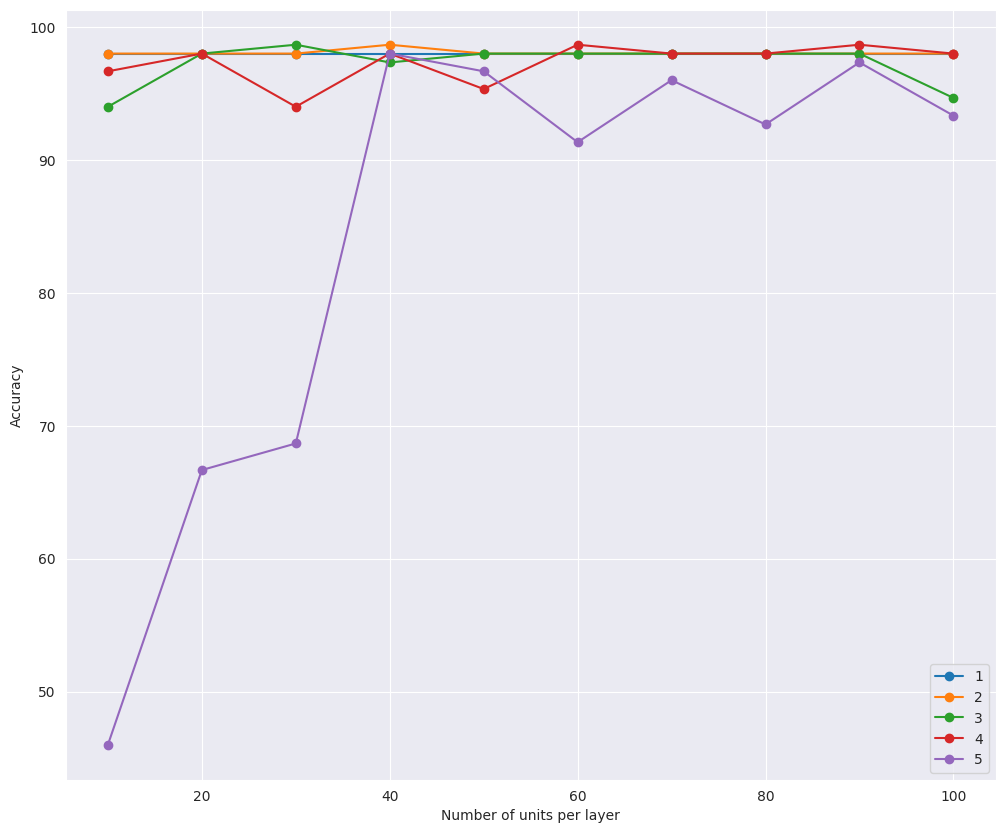

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(units, accuracies.transpose(), "o-")
ax.set_xlabel("Number of units per layer")
ax.set_ylabel("Accuracy")

ax.legend(layers)
ax.grid(True)

plt.show()

In [15]:
accuracies.shape

(5, 10)

In [16]:
accuracies.flatten()

array([98.        , 98.        , 98.        , 98.        , 98.        ,
       98.        , 98.        , 98.        , 98.        , 98.        ,
       98.        , 98.        , 98.        , 98.66667175, 98.        ,
       98.        , 98.        , 98.        , 98.        , 98.        ,
       94.        , 98.        , 98.66667175, 97.33333588, 98.        ,
       98.        , 98.        , 98.        , 98.        , 94.66666412,
       96.66666412, 98.        , 94.        , 98.        , 95.33332825,
       98.66667175, 98.        , 98.        , 98.66667175, 98.        ,
       46.        , 66.66667175, 68.66666412, 98.        , 96.66666412,
       91.33333588, 96.        , 92.66666412, 97.33333588, 93.33333588])

In [17]:
accuracies.flatten().shape

(50,)

In [18]:
total_params.flatten().shape

(50,)

<Axes: >

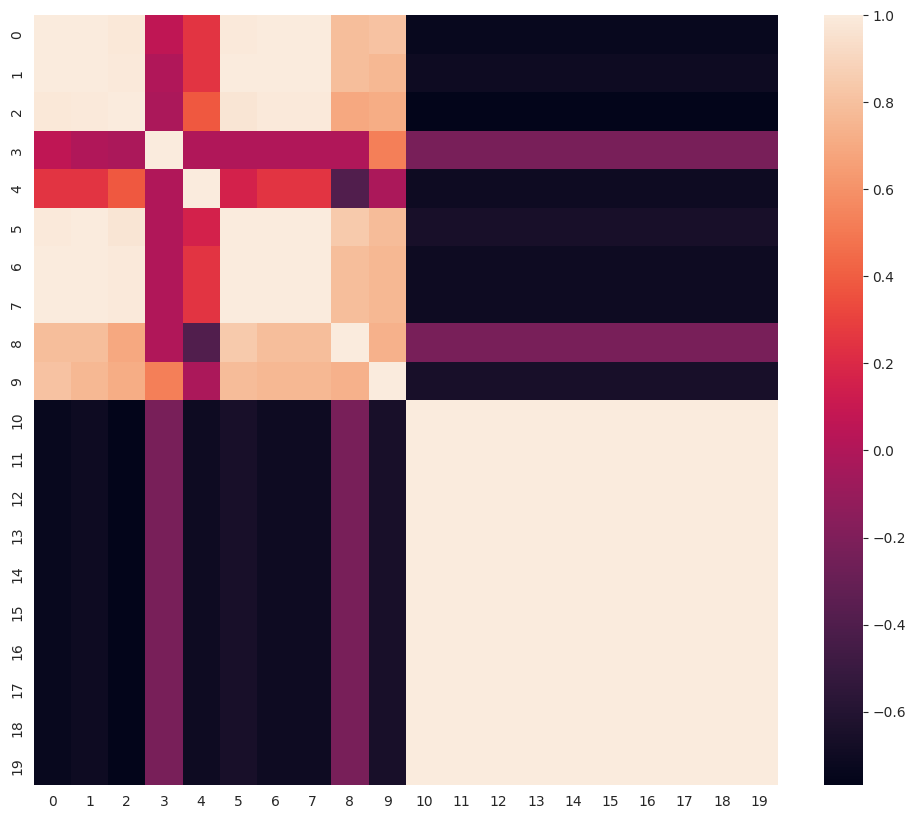

In [22]:
acc_params_corr = np.corrcoef(accuracies.transpose(), total_params.transpose())

fig, ax = plt.subplots(figsize=(12, 10))
sn.heatmap(acc_params_corr, ax=ax)

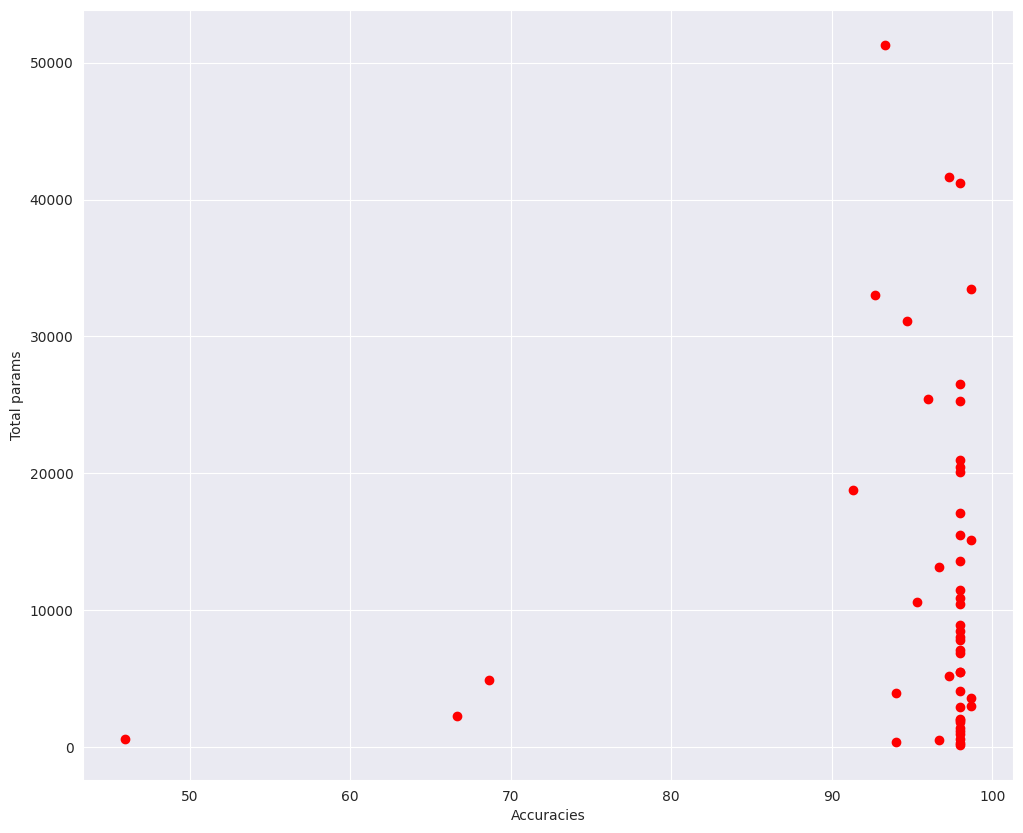

In [24]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(accuracies.flatten(), total_params.flatten(), "ro")

ax.set_xlabel("Accuracies")
ax.set_ylabel("Total params")
ax.grid(True)

plt.show()